In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import timeseries_dataset_from_array

2023-04-10 15:24:34.276983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# TODO
- linear interpolation
- normalise for each person separately
- join into a single csv and save

Split data

In [2]:
pd.set_option("display.max_row", 40)

In [3]:
data_list = []
for i in range(0, 27):
    df = pd.read_csv(f"data/aggregated_individual_data_interpolation/interpolation/{i}_interpolated.csv", index_col=0)
    df["subject_id"] = i+1
    data_list.append(df)

# Concatenate the data into a single dataset
data = pd.concat(data_list)
data.drop(["circumplex.arousal_std","circumplex.valence_std","mood_std","activity_std"], inplace=True,axis=1)

Single person: Split (70,20,10)

-------

Normalise using z-score normalisation. Avoid data leakage by normalising only with the training set.

----------------

In [4]:
df = data
df.reset_index(inplace=True,drop=True)
df = df.astype({'subject_id': 'float64','days': 'float64','weekday': 'float64'})

In [5]:
date_time = pd.to_datetime(df.pop('date'))
df['days'] = date_time
# date_time
# df.drop("date", inplace=True,axis=1)

In [6]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days' 
IN_STEPS = 24
OUT_STEPS = 24  
GROUPBY = ['subject_id']
BATCH_SIZE = 8

Do split

In [7]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

((804, 22), (234, 22), (130, 22))

In [8]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    self.GROUPBY = GROUPBY 
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}', 
        f'GROUPBY column(s): {self.GROUPBY}' 
        ])

  def preprocess_dataset(self, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index() 

      by = self.GROUPBY + [DATE] 
      labels = self.label_columns + self.regressor_columns + self.static_columns
      data = data.set_index(by).unstack(-1)
      data = tf.stack([data[label] for label in labels], axis=-1)
      
      if data.ndim != 3:
          data = data[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return data

  def update_datasets(self, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm:
      train_mean = tf.reduce_mean(self.train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(self.train_df, axis=1, keepdims=True)

      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      self.train_mean = train_mean 
      self.train_std = train_std 
      self.norm = norm 

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}


In [9]:
w1 = MultiSeriesWindowsGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=BATCH_SIZE, label_columns=LABELS, GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w1.update_datasets(train_series, val_series, test_series, norm=True)

2023-04-10 15:24:41.942829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Batch Size: 8
Label column name(s): ['mood']
Additional Regressor column name(s): ['weekday', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']
GROUPBY column(s): ['subject_id']

In [11]:
def split_window(self, features:tf.Tensor):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None: 
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] 
          for name in self.label_columns], axis=-1)
          
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels 
MultiSeriesWindowsGenerator.split_window = split_window

Example 

In [12]:
df.set_index(GROUPBY + [DATE])[:w1.total_window_size]

weekday      mood  circumplex.arousal  \
subject_id days                                                
1.0        2014-03-21      4.0  6.200000                 0.2   
           2014-03-22      5.0  6.400000                 0.6   
           2014-03-23      6.0  6.800000                 0.2   
           2014-03-24      0.0  6.000000                 0.8   
           2014-03-25      1.0  6.750000                 0.5   
...                        ...       ...                 ...   
           2014-05-03      5.0  8.000000                -0.2   
           2014-05-04      6.0  8.000000                -0.5   
2.0        2014-03-16      6.0  6.333333                 0.0   
           2014-03-17      0.0  6.750000                 0.5   
           2014-03-18      1.0  8.200000                 0.6   

                       circumplex.valence  activity        screen  call  sms  \
subject_id days                                                                
1.0        2014-03-21                 0.2  0.134050  17978.907000   6.0  0.0   
           2014-03-22                 0.5  0.236880   6142.161000   3.0  1.0   
           2014-03-23                 0.8  0.142741   6773.832001   0.0  0.0   
           2014-03-24                 0.0  0.078961  15047.351001  10.0  0.0   
           2014-03-25                 0.5  0.098374  21475.354999   0.0  1.0   
...                                   ...       ...           ...   ...  ...   
           2014-05-03                 1.0  0.071741   8186.036001   0.0  1.0   
           2014-05-04                 1.0  0.136192   5889.194999   0.0  0.0   
2.0        2014-03-16                 0.0       NaN   4902.627000   4.0  1.0   
           2014-03-17                 0.5  0.168068  10159.769001   4.0  0.0   
           2014-03-18                 0.8  0.219484   4512.471001  15.0  1.0   

                       appCat.builtin  appCat.communication  \
subject_id days                                               
1.0        2014-03-21        3139.218              6280.890   
           2014-03-22         731.429              4962.918   
           2014-03-23        1286.246              5237.319   
           2014-03-24         866.956              9270.629   
           2014-03-25        1032.768             10276.751   
...                               ...                   ...   
           2014-05-03         753.257              4539.776   
           2014-05-04        1758.438              3381.689   
2.0        2014-03-16        2526.424              3151.829   
           2014-03-17        1229.347              4518.116   
           2014-03-18        2604.521              3933.081   

                       appCat.entertainment  appCat.finance  appCat.game  \
subject_id days                                                            
1.0        2014-03-21              1007.456          49.544          0.0   
           2014-03-22                93.324          21.076          0.0   
           2014-03-23                94.346          43.403          0.0   
           2014-03-24               976.971          34.106          0.0   
           2014-03-25                68.206          43.054          0.0   
...                                     ...             ...          ...   
           2014-05-03              2761.950         296.313          0.0   
           2014-05-04               928.406           0.000          0.0   
2.0        2014-03-16                88.392           0.000          0.0   
           2014-03-17              2511.178           0.000          0.0   
           2014-03-18                88.943           0.000          0.0   

                       appCat.office  appCat.other  appCat.social  \
subject_id days                                                     
1.0        2014-03-21        172.206       239.751       4508.500   
           2014-03-22          0.000        98.143        439.632   
           2014-03-23          0.000        72.823        900.83

In [13]:
example_window = tf.stack([
    np.array(df.set_index(GROUPBY + [DATE])[:w1.total_window_size]), 
    np.array(df.set_index(GROUPBY + [DATE])[2:2+w1.total_window_size]),
    np.array(df.set_index(GROUPBY + [DATE])[4:4+w1.total_window_size])
])

example_window = tf.stack([
    np.array(df.set_index(GROUPBY + [DATE])[:w1.total_window_size])
])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (1, 48, 20)
Inputs shape: (1, 24, 20)
Labels shape: (1, 24, 1)


In [14]:
w1.example = (example_inputs, example_labels)

def plot(self, model=None, plot_col=LABELS[0], max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

MultiSeriesWindowsGenerator.plot = plot

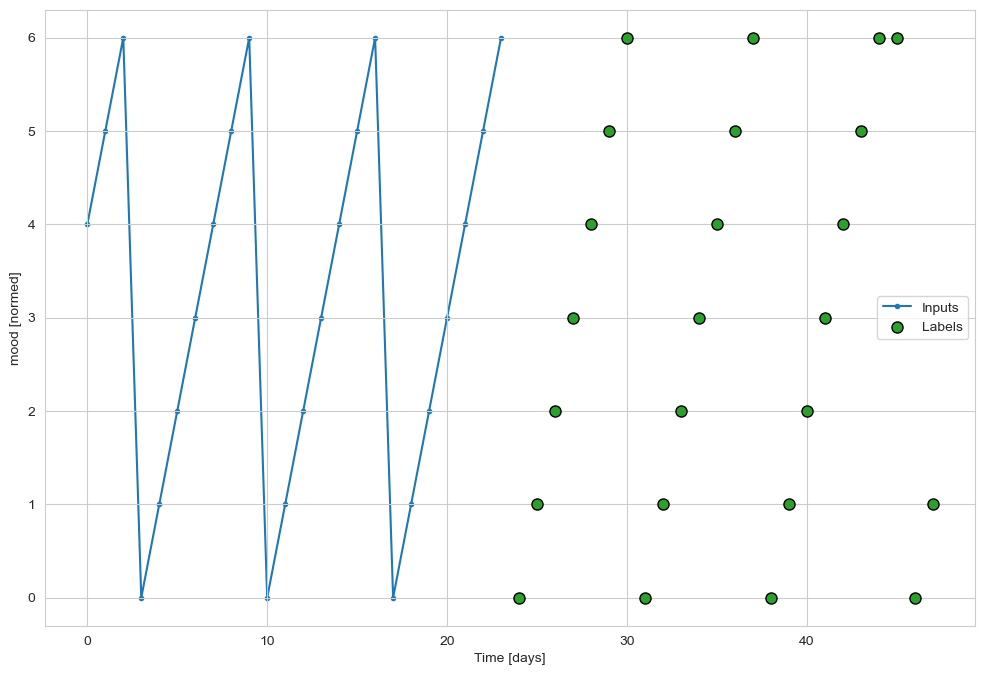

In [15]:
w1.plot()

In [16]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32) 
    ds = timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=True, 
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window) 
    return ds 

MultiSeriesWindowsGenerator.make_cohort = make_cohort

In [17]:
"""
Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0) 
    labels = tf.concat([window[1] for window in windows], 0) 
    return (features, labels)
    
def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:    
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch() 
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size) 
    ds = ds.prefetch(1)
    return ds 

MultiSeriesWindowsGenerator.make_dataset = make_dataset

In [18]:
w1.train_df

<tf.Tensor: shape=(27, 70, 20), dtype=float64, numpy=
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan,

In [19]:
w1.make_dataset(w1.train_df)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 24, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))>

In [20]:
w1.make_dataset(w1.train_df)

In [21]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property 
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property 
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None) 
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None: 
        result = next(iter(self.train)) 
        self._example = result 
    return result 

MultiSeriesWindowsGenerator.train = train 
MultiSeriesWindowsGenerator.test = test 
MultiSeriesWindowsGenerator.val = val 
MultiSeriesWindowsGenerator.example = example 

Inputs shape (batch, time, features): (8, 24, 20)
Labels shape (batch, time, features): (8, 24, 1)
Inputs shape (batch, time, features): (8, 24, 20)
Labels shape (batch, time, features): (8, 24, 1)


In [22]:
for example_inputs, example_labels in w1.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [23]:
def plot(self, model=None, plot_col=LABELS[0], max_subplots=10):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [MS]')

MultiSeriesWindowsGenerator.plot = plot

SyntaxError: expected 'else' after 'if' expression (3024283581.py, line 1)

Try fitting baseline model to test if preprocessing works

In [ ]:
w2 = MultiSeriesWindowsGenerator(input_width=6, label_width=1,
                                 shift=1, batch_size=5, label_columns=["mood"],
                                 GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w2.update_datasets(train_series, val_series, test_series, norm=True)


In [ ]:
train_series[:w2.total_window_size].dtypes

In [ ]:
# Stack three slices, the length of the total window.

example_window = tf.stack([np.array(train_series[:w2.total_window_size]),
                           np.array(train_series[100:100+w2.total_window_size]),
                           np.array(train_series[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
w1.column_indices[LABELS[0]]

In [ ]:
baseline = Baseline(label_index=w1.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

In [ ]:
w1.plot(baseline)

Single person: Split (70,20,10)

-------

In [ ]:
# subj_1 = data[data["subject_id"]==1]
# subj_1

In [ ]:
# column_indices = {name: i for i, name in enumerate(subj_1.columns)}

# n = len(subj_1)
# train_df = subj_1[0:int(n*0.7)]
# val_df = subj_1[int(n*0.7):int(n*0.9)]
# test_df = subj_1[int(n*0.9):]

In [ ]:
# test_df

Normalise using z-score normalisation. Avoid data leakage by normalising only with the training set.

In [ ]:
# train_mean = train_df.mean(numeric_only=True)
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [ ]:
# train_df["subject_id"] = 1
# val_df["subject_id"] = 1
# test_df["subject_id"] = 1
# test_df.columns

----------------

In [ ]:
df = data
df.reset_index(inplace=True,drop=True)
df

In [ ]:
# date_time = pd.to_datetime(df.pop('date'))
# # df['date'] = df["days"]


In [ ]:
LABELS = ['mood']
REGRESSORS = ['weekday', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

DATE = 'days' 
IN_STEPS = 24
OUT_STEPS = 24  
GROUPBY = ['subject_id']
BATCH_SIZE = 8

Do split

In [ ]:
n = len(df)
train_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[:int(len(x) * 0.7)]).reset_index(drop=True)
val_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.7):int(len(x) * 0.9)]).reset_index(drop=True)
test_series = df.groupby(GROUPBY, as_index=False, group_keys=False).apply(lambda x: x.iloc[int(len(x) * 0.9):]).reset_index(drop=True)
train_series.shape, val_series.shape, test_series.shape

In [ ]:
class MultiSeriesWindowsGenerator():
  def __init__(self, input_width, label_width, shift, batch_size, label_columns=[], GROUPBY=None, regressor_columns=[], static_columns=[]):

    self.batch_size = batch_size

    # Work out the label column indices.
    self.label_columns = label_columns
    if len(label_columns) != 0:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    
    self.GROUPBY = GROUPBY 
    self.regressor_columns = regressor_columns
    self.static_columns = static_columns

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Batch Size: {self.batch_size}',
        f'Label column name(s): {self.label_columns}',
        f'Additional Regressor column name(s): {self.regressor_columns}', 
        f'GROUPBY column(s): {self.GROUPBY}' 
        ])

  def preprocess_dataset(self, data:pd.DataFrame):
    try:
      if np.vstack(data.index).shape[1] != 1:
        data = data.reset_index() 

      by = self.GROUPBY + [DATE] 
      labels = self.label_columns + self.regressor_columns + self.static_columns
      data = data.set_index(by).unstack(-1)
      data = tf.stack([data[label] for label in labels], axis=-1)
      
      if data.ndim != 3:
          data = data[None, None, tf.newaxis]
    except Exception as e:
      print('Error while processing dataset', e)
    return data

  def update_datasets(self, train_df:pd.DataFrame, val_df:pd.DataFrame, test_df:pd.DataFrame, norm:bool=False):
    # Store the raw data.
    self.train_df = self.preprocess_dataset(train_df)
    self.val_df = self.preprocess_dataset(val_df)
    self.test_df = self.preprocess_dataset(test_df)

    if norm:
      train_mean = tf.reduce_mean(self.train_df, axis=1, keepdims=True)
      train_std = tf.math.reduce_std(self.train_df, axis=1, keepdims=True)

      self.train_df = (self.train_df - train_mean) / train_std
      self.val_df = (self.val_df - train_mean) / train_std
      self.test_df = (self.test_df - train_mean) / train_std

      self.train_mean = train_mean 
      self.train_std = train_std 
      self.norm = norm 

    labels = self.label_columns + self.regressor_columns + self.static_columns
    self.column_indices = {name: i for i, name in enumerate(labels)}


In [ ]:
w1 = MultiSeriesWindowsGenerator(input_width=IN_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS, batch_size=BATCH_SIZE, label_columns=LABELS, GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w1.update_datasets(train_series, val_series, test_series, norm=True)

In [ ]:
w1

In [ ]:
def make_cohort(self, data:np.array) -> tf.data.Dataset:
    data = np.array(data, dtype=np.float32) 
    ds = timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size, 
        sequence_stride=1, 
        shuffle=True, 
        batch_size=self.batch_size
    )
    ds = ds.map(self.split_window) 
    return ds 

MultiSeriesWindowsGenerator.make_cohort = make_cohort

In [ ]:
"""
Reference code from https://stackoverflow.com/questions/49994496/mixing-multiple-tf-data-dataset
"""

def stack_windows(*windows):
    features = tf.concat([window[0] for window in windows], 0) 
    labels = tf.concat([window[1] for window in windows], 0) 
    return (features, labels)
    
def make_dataset(self, data:tf.Tensor) -> tf.data.Dataset:    
    # num_cohorts = min(10, len(cluster_cohorts))
    # print(cluster, num_cohorts)
    ds_list = tuple(self.make_cohort(data[i]) for i in range(len(data)))
    ds = tf.data.Dataset.zip(ds_list)
    ds = ds.map(stack_windows)
    ds = ds.unbatch() 
    ds = ds.shuffle(10, seed=0)
    ds = ds.batch(self.batch_size) 
    ds = ds.prefetch(1)
    return ds 

MultiSeriesWindowsGenerator.make_dataset = make_dataset

In [ ]:
w1.make_dataset(w1.train_df)

In [ ]:
@property
def train(self) -> tf.data.Dataset:
    return self.make_dataset(self.train_df)

@property 
def val(self) -> tf.data.Dataset:
    return self.make_dataset(self.val_df)

@property 
def test(self) -> tf.data.Dataset:
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting"""
    result = getattr(self, '_example', None) 
    print('Number of train batches:', len(list(self.train.as_numpy_iterator())))
    if result is None: 
        result = next(iter(self.train)) 
        self._example = result 
    return result 

MultiSeriesWindowsGenerator.train = train 
MultiSeriesWindowsGenerator.test = test 
MultiSeriesWindowsGenerator.val = val 
MultiSeriesWindowsGenerator.example = example 

In [ ]:
for example_inputs, example_labels in w1.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
def plot(self, model=None, plot_col=LABELS[0], max_subplots=10):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} {"[normed]" if self.norm else ""}')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [MS]')

MultiSeriesWindowsGenerator.plot = plot

Try fitting baseline model to test if preprocessing works

In [ ]:
w2 = MultiSeriesWindowsGenerator(input_width=6, label_width=1,
                                 shift=1, batch_size=5, label_columns=["mood"],
                                 GROUPBY=GROUPBY, regressor_columns=REGRESSORS)
w2.update_datasets(train_series, val_series, test_series, norm=True)


In [ ]:
train_series.drop("date", axis=1, inplace=True)

In [ ]:
# Stack three slices, the length of the total window.

example_window = tf.stack([np.array(train_series[:w2.total_window_size]),
                           np.array(train_series[100:100+w2.total_window_size]),
                           np.array(train_series[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
w1.column_indices[LABELS[0]]

In [ ]:
w1

In [ ]:
baseline = Baseline(label_index=w1.column_indices[LABELS[0]])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w1.val)
performance['Baseline'] = baseline.evaluate(w1.test, verbose=0)

In [ ]:
w1.plot(baseline)